# LRR Annotator example on Arabidillo

Below is example usage of the LRR annotator run on The Arabidillo protein, which contains both Ankyrin and LRR repeat domains.

The `Loader`, `Analyzer`, and `Plotter` objects load PDB files from disk, analyze them / perform regressions, and produce winding number plots.

Make sure to `pip install -e .` from the directory containing `setup.py` before running this code. (Recommended to do this inside a Conda environment, or virtual environment,
so that dependencies installed don't interfere with your existing `pip`). 

In [1]:
from lrr_annot import Loader, Analyzer, Plotter

In [2]:
L = Loader()
A = Analyzer()
P = Plotter()

In [3]:
L.load_batch('./pdb/misc')
A.load_structures(L.structures)
A.compute_windings()
A.compute_regressions()

Computing regressions: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


In [ ]:
def compute_regression(winding, n_breakpoints=2, penalties=[1, 1.5], learning_rate=0.01, iterations=10000, initial_guess=[]):
    """
    Computes piecewise-linear regressions (constant - slope = m - constant) over
    all cumulative winding curves stored in the `winding` dictionary. Writes the parameters
    of these regressions to the `parameters` and `slopes` dictionaries.

    Parameters
    ----------
    winding: ndarray(n)
        The winding number at each residue
    n_breakpoints: int (optional)
        How many breakpoints to use
    penalties: list[float, float] (optional)
        Two-element list describing the relative penalties, in the loss function, of deviation. 
        The first component refers to the non-coiling regions; the second to the coiling region.
        Defaults to [1, 1.5].
    learning_rate: float (optional)
        Scalar for gradient descent in parameter optimization. Defaults to 0.01.
        iterations (int, optional): Iterations of gradient descent. Defaults to 10000.
    iterations: int (optional)
        Number of iterations in gradient descent.  Defaults to 10000
    initial_guess: list of float (optional)
        An initial guess of the breakpoint locations.  If not specified, initial conditions
        will be taken as equally spaced.
    
    Returns
    -------
    {
        slope: float
            Estimated slope in each winding segment
        breakpoints: ndarray(int)
            Residue locations of the breakpoints
        loss: float
            Final loss from the regression
    }
    """
    n = len(winding)

    if len(initial_guess) > 0:
        breakpoints = np.array(initial_guess)
    else:
        # best-guess initialization
        breakpoints = n * (1 + np.arange(n_breakpoints)) / (n_breakpoints + 1)
    gradient = np.zeros(n_breakpoints)
    delta = [*np.identity(n_breakpoints)]

    m, _ = median_slope(winding)

    for _ in range(iterations):
        present = multi_loss(winding, breakpoints, m, penalties)
        # Compute a finite difference approximation of the gradient
        gradient = np.array([multi_loss(winding, breakpoints + d, m, penalties) - present for d in delta])
        breakpoints = breakpoints - learning_rate * gradient
        # Safeguards
        breakpoints[breakpoints > winding.size] = winding.size
        breakpoints = np.sort(breakpoints)

    # if breakpoints[-1] > 0.9 * n:
    #     breakpoints[-1] = len(winding)

    return dict(
        slope=m,
        breakpoints=np.array(breakpoints, dtype=int),
        loss=present
    )

Computing regressions: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Winding number computation on Arabidillo

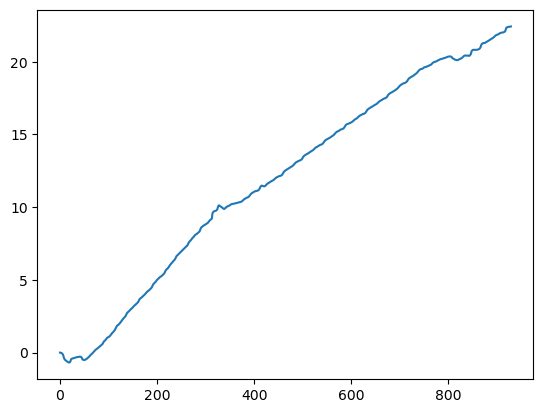

In [25]:
import matplotlib.pyplot as plt
plt.plot(A.windings['arabidillo'])

In [4]:
P.load(A.windings, A.regressions, A.slopes)

In [5]:
P.plot_regressions(save = True, directory = './plots')

Making plots: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:08<00:00, 21.96it/s]
